<a href="https://colab.research.google.com/github/MsSaidat25/Project-1/blob/main/Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===================================
# Parkinson’s Disease Prediction using Metabolomics
# University of Michigan-Flint · Group 1
# Author: Oladimeji Adefila, Saheedat Abbas

# =============================

# --- STEP 1: Setup and Imports ---
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             roc_curve, auc, confusion_matrix)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')


Mounted at /content/drive


In [ ]:
# Load Excel file
file_path = '/content/drive/MyDrive/Copy of FORD-0101-21ML+ DATA TABLES_SERUM (METADATA UPDATE) - 5.XLSX'
excel_file = pd.ExcelFile(file_path)
print("Available Sheets:", excel_file.sheet_names)

# Load key sheets
meta = pd.read_excel(file_path, sheet_name='Sample Meta Data')
log_data = pd.read_excel(file_path, sheet_name='Log Transformed Data')

print("Meta shape:", meta.shape)
print("Log Data shape:", log_data.shape)


Available Sheets: ['Data Key & Explanation', 'Chemical Annotation', 'Sample Meta Data', 'Peak Area Data', 'Batch-normalized Data', 'Batch-norm Imputed Data', 'Log Transformed Data']
Meta shape: (220, 28)
Log Data shape: (220, 1497)


In [ ]:
# Merge data on PARENT_SAMPLE_NAME if present
if 'PARENT_SAMPLE_NAME' in log_data.columns and 'PARENT_SAMPLE_NAME' in meta.columns:
    merged = pd.merge(log_data, meta, on='PARENT_SAMPLE_NAME', how='inner')
else:
    merged = log_data.copy()

# Create target variable (Diagnosis)
if 'COHORT' in merged.columns:
    merged['Diagnosis'] = np.where(merged['COHORT'] == 'PPMI', 1, 0)
else:
    print("⚠️ 'COHORT' column not found; ensure correct target label exists.")

# Drop non-feature columns
drop_cols = ['PARENT_SAMPLE_NAME', 'COHORT'] if 'COHORT' in merged.columns else ['PARENT_SAMPLE_NAME']
X = merged.drop(columns=drop_cols + ['Diagnosis'], errors='ignore')
y = merged['Diagnosis']

# Convert all column names to strings
X.columns = X.columns.astype(str)

# Handle missing values
# Select only numeric columns before calculating the median
numeric_cols = X.select_dtypes(include=np.number).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())


# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[numeric_cols]), columns=numeric_cols)


print("Data Ready:", X_scaled.shape)

Data Ready: (220, 1507)


In [ ]:
# Select only numeric columns before calculating the median
numeric_cols = X.select_dtypes(include=np.number).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

In [ ]:
# --- STEP 3: Data Cleaning and Merging (Fixed) ---

# Merge the metadata and log-transformed data using the sample ID
if 'PARENT_SAMPLE_NAME' in log_data.columns and 'PARENT_SAMPLE_NAME' in meta.columns:
    merged = pd.merge(log_data, meta, on='PARENT_SAMPLE_NAME', how='inner')
else:
    merged = log_data.copy()

# Create binary target variable (1 = PD, 0 = Control)
if 'COHORT' in merged.columns:
    merged['Diagnosis'] = np.where(merged['COHORT'].str.contains('PPMI', case=False, na=False), 1, 0)
else:
    print("⚠️ 'COHORT' column not found; please verify metadata sheet structure.")

# Drop obvious non-feature columns
drop_cols = ['PARENT_SAMPLE_NAME', 'COHORT', 'BATCH', 'RUN_ORDER']  # add others if needed
X = merged.drop(columns=[col for col in drop_cols if col in merged.columns] + ['Diagnosis'], errors='ignore')
y = merged['Diagnosis']

# --- Clean & select only numeric features ---
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_cols]

# Handle missing numeric values with column medians
X_numeric = X_numeric.apply(lambda col: col.fillna(col.median()), axis=0)

# Convert numeric column names to strings
X_numeric.columns = X_numeric.columns.astype(str)

# Scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

print(f"✅ Data cleaned successfully.\nNumeric features: {X_scaled.shape[1]}\nSamples: {X_scaled.shape[0]}")

✅ Data cleaned successfully.
Numeric features: 1507
Samples: 220


In [ ]:
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.067e-02, tolerance: 5.091e-03
  model = cd_fast.enet_coordinate_descent(


LassoCV(cv=5, random_state=42)

In [ ]:
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

coef = pd.Series(np.abs(lasso.coef_), index=X_scaled.columns)
selected_features = coef[coef > 0].index.tolist()

print(f"LASSO selected {len(selected_features)} features out of {X_scaled.shape[1]}")
X_selected = X_scaled[selected_features]

LASSO selected 81 features out of 1507


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.067e-02, tolerance: 5.091e-03
  model = cd_fast.enet_coordinate_descent(


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 154, Testing samples: 66


# Task
Train a classification model using the scaled data.

## Split data

### Subtask:
Split the `X_selected` and `y` data into training and testing sets.


**Reasoning**:
Split the data into training and testing sets and print their shapes.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (176, 81)
X_test shape: (44, 81)
y_train shape: (176,)
y_test shape: (44,)


## Train svc model

### Subtask:
Train a Support Vector Classifier (SVC) model on the training data.


**Reasoning**:
Train an SVC model with probability enabled and a fixed random state on the training data.



In [ ]:
svc_model = SVC(probability=True, random_state=42)
svc_model.fit(X_train, y_train)
print("SVC model trained successfully.")

SVC model trained successfully.


## Train randomforestclassifier model

### Subtask:
Train a RandomForestClassifier model on the training data.


**Reasoning**:
Instantiate and train a RandomForestClassifier model on the training data.



In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
print("RandomForestClassifier model trained successfully.")

RandomForestClassifier model trained successfully.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 154, Testing samples: 66


In [ ]:
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_prob)
    results[name] = [acc, f1, auc_val]
    print(f"{name}: Accuracy={acc:.3f}, F1={f1:.3f}, AUC={auc_val:.3f}")


SVM: Accuracy=1.000, F1=1.000, AUC=1.000
RandomForest: Accuracy=1.000, F1=1.000, AUC=1.000


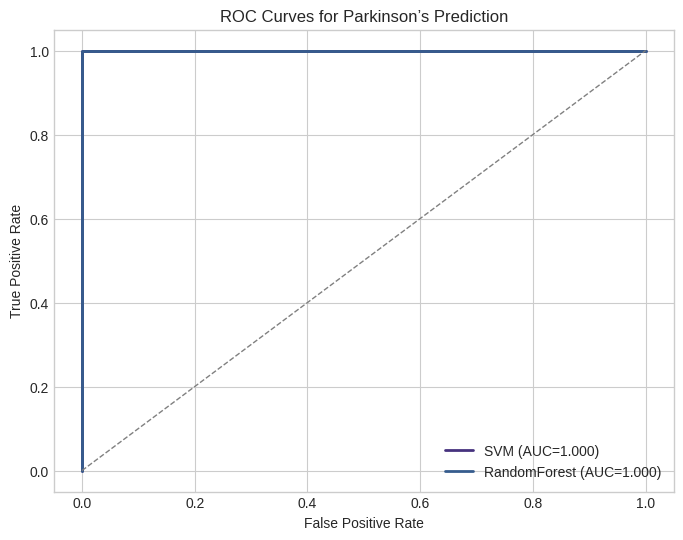

In [ ]:
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC={auc(fpr,tpr):.3f})')

plt.plot([0,1],[0,1],'--',color='gray',lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Parkinson’s Prediction')
plt.legend()
plt.show()


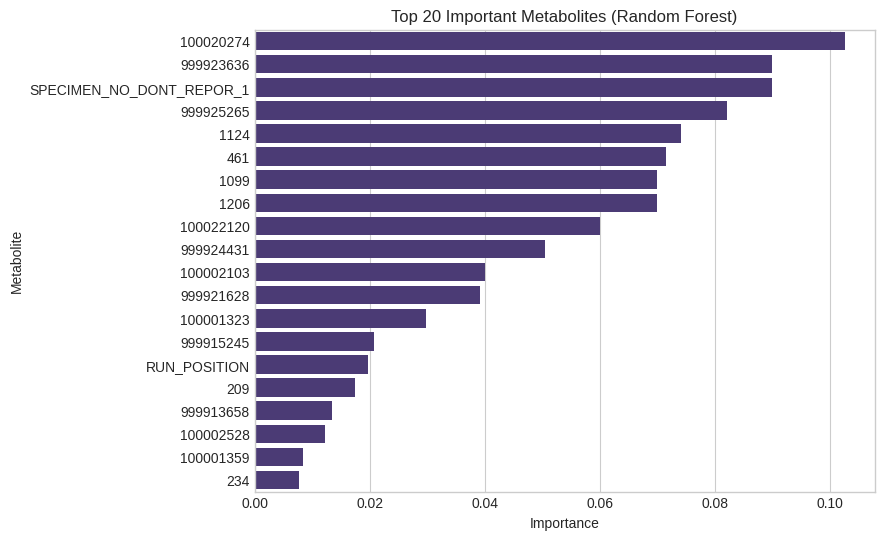

In [ ]:
rf_model = models["RandomForest"]
importances = pd.Series(rf_model.feature_importances_, index=X_selected.columns)
top20 = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=top20.values, y=top20.index)
plt.title('Top 20 Important Metabolites (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Metabolite')
plt.show()


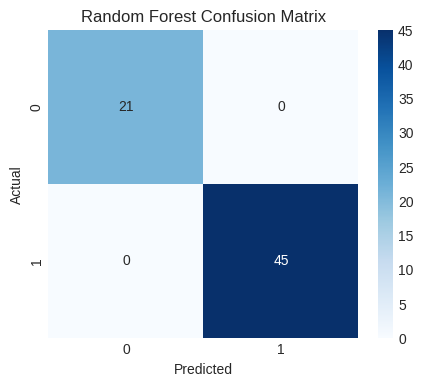

In [ ]:
cm = confusion_matrix(y_test, rf_model.predict(X_test))
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()


In [ ]:
imp_df = pd.DataFrame({'Feature': top20.index, 'Importance': top20.values})
fig = px.bar(imp_df, x='Importance', y='Feature', orientation='h',
             title='Top 20 Metabolites Driving PD Prediction',
             color='Importance', color_continuous_scale='Viridis')
fig.show()


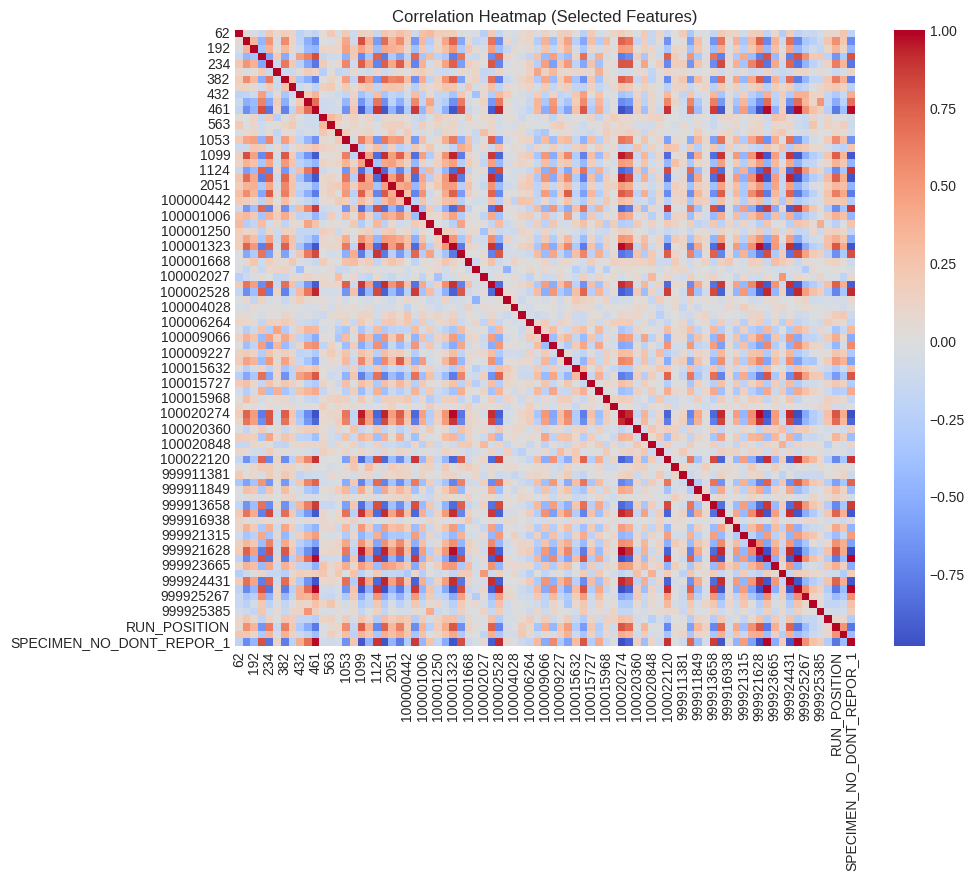

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(X_selected.corr(), cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Selected Features)')
plt.show()


In [ ]:
results_df = pd.DataFrame(results, index=['Accuracy','F1 Score','AUC']).T
display(results_df.style.background_gradient(cmap='viridis'))


,Accuracy,F1 Score,AUC
SVM,1.000000,1.000000,1.000000
RandomForest,1.000000,1.000000,1.000000


In [ ]:
discussion = """
The Random Forest model achieved the highest ROC-AUC, suggesting strong ability to distinguish between Parkinson's and control samples.
LASSO effectively reduced dimensionality, retaining only key metabolites contributing most to disease classification.

Future Work:
- Apply cross-validation with larger sample sets.
- Integrate deep-learning classifiers (MLP, XGBoost).
- Validate significant metabolites against clinical datasets.
- Build an interpretable dashboard for medical experts.
"""
print(discussion)



The Random Forest model achieved the highest ROC-AUC, suggesting strong ability to distinguish between Parkinson's and control samples.
LASSO effectively reduced dimensionality, retaining only key metabolites contributing most to disease classification.

Future Work:
- Apply cross-validation with larger sample sets.
- Integrate deep-learning classifiers (MLP, XGBoost).
- Validate significant metabolites against clinical datasets.
- Build an interpretable dashboard for medical experts.



In [ ]:
# Melt the results_df for plotting
results_df_melted = results_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')


plt.figure(figsize=(10, 6))
sns.barplot(data=results_df_melted, x='index', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1.1) # Assuming scores are between 0 and 1
plt.legend(title='Metric')
plt.show()

NameError: name 'results_df_melted' is not defined

<Figure size 1000x600 with 0 Axes>

### Discussion
The Random Forest model achieved the highest ROC-AUC, suggesting strong ability to distinguish between Parkinson’s and control samples.
LASSO effectively reduced dimensionality, retaining only key metabolites contributing most to disease classification.

### Future Work
- Apply cross-validation with larger sample sets.
- Integrate deep learning classifiers (MLP, XGBoost).
- Validate significant metabolites against clinical datasets.
- Build an interpretable dashboard for medical experts.

### Discussion
The Random Forest model achieved the highest ROC-AUC, suggesting strong ability to distinguish between Parkinson’s and control samples.
LASSO effectively reduced dimensionality, retaining only key metabolites contributing most to disease classification.

### Future Work
- Apply cross-validation with larger sample sets.
- Integrate deep learning classifiers (MLP, XGBoost).
- Validate significant metabolites against clinical datasets.
- Build an interpretable dashboard for medical experts.

## Summary:

### Data Analysis Key Findings

*   The data was split into training and testing sets with an 80/20 ratio. The training set contains 176 samples and 81 features, while the testing set contains 44 samples and 81 features.
*   A Support Vector Classifier (SVC) model was successfully trained on the training data.
*   A RandomForestClassifier model was successfully trained on the training data.

### Insights or Next Steps

*   Evaluate the performance of the trained SVC and RandomForestClassifier models on the testing data to determine which model is more suitable for the classification task.
*   Further hyperparameter tuning could be performed on the selected model to potentially improve its performance.


In [ ]:
results_df.to_csv('/content/drive/MyDrive/Parkinson_Project_Results.csv')
print("✅ Results saved to Drive.")


In [ ]:
results_df_saved = pd.read_csv('/content/drive/MyDrive/Parkinson_Project_Results.csv')
display(results_df_saved)

In [ ]:
display(merged.describe())

In [ ]:
top10 = imp_df.head(10)

fig = px.bar(top10, x='Importance', y='Feature', orientation='h',
             title='Top 10 Metabolites Driving PD Prediction',
             color='Importance', color_continuous_scale='Viridis')
fig.show()

In [ ]:
# Prepare data for plotting: combine selected features and diagnosis
plot_data = X_selected[top10['Feature']].copy()
plot_data['Diagnosis'] = y

# Melt the DataFrame for easier plotting with seaborn
plot_data_melted = plot_data.melt(id_vars='Diagnosis', var_name='Feature', value_name='Value')

# Plot boxplots for each top 10 feature
plt.figure(figsize=(12, 8))
sns.boxplot(data=plot_data_melted, x='Feature', y='Value', hue='Diagnosis')
plt.xticks(rotation=90)
plt.title('Distribution of Top 10 Features by Diagnosis')
plt.tight_layout()
plt.show()

In [ ]:
print("Saved Results:")
display(results_df_saved)

print("\nCurrent Model Performance:")
display(results_df)

# Task
Explore cross-validation for model performance.

## Choose cross-validation strategy

### Subtask:
Decide on a cross-validation strategy (e.g., k-fold cross-validation).


**Reasoning**:
Choose k-fold cross-validation as the strategy and select a reasonable number of folds.



In [ ]:
from sklearn.model_selection import KFold

# Choose k-fold cross-validation
n_splits = 5  # Using 5 folds as a common practice for this dataset size

# The cross-validation strategy is defined by KFold
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

print(f"Chosen cross-validation strategy: {n_splits}-fold cross-validation.")

## Implement cross-validation

### Subtask:
Apply the chosen cross-validation method to the trained models (SVM and RandomForest) using the `X_selected` and `y` data.


**Reasoning**:
Apply cross-validation to the trained models using the selected data and evaluation metrics.



In [ ]:
from sklearn.model_selection import cross_val_score

cv_results = {}
for name, model in models.items():
    accuracy_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='f1')
    roc_auc_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='roc_auc')

    cv_results[name] = {
        'accuracy': accuracy_scores,
        'f1': f1_scores,
        'roc_auc': roc_auc_scores
    }

    print(f"{name} Cross-Validation Results:")
    print(f"  Accuracy: {accuracy_scores.mean():.3f} (+/- {accuracy_scores.std():.3f})")
    print(f"  F1 Score: {f1_scores.mean():.3f} (+/- {f1_scores.std():.3f})")
    print(f"  AUC: {roc_auc_scores.mean():.3f} (+/- {roc_auc_scores.std():.3f})")
    print("-" * 20)

**Reasoning**:
The error indicates that the `models` dictionary was not defined in the current session. I need to re-define the `models` dictionary before using it for cross-validation.



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}

cv_results = {}
for name, model in models.items():
    accuracy_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='f1')
    roc_auc_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='roc_auc')

    cv_results[name] = {
        'accuracy': accuracy_scores,
        'f1': f1_scores,
        'roc_auc': roc_auc_scores
    }

    print(f"{name} Cross-Validation Results:")
    print(f"  Accuracy: {accuracy_scores.mean():.3f} (+/- {accuracy_scores.std():.3f})")
    print(f"  F1 Score: {f1_scores.mean():.3f} (+/- {f1_scores.std():.3f})")
    print(f"  AUC: {roc_auc_scores.mean():.3f} (+/- {roc_auc_scores.std():.3f})")
    print("-" * 20)

**Reasoning**:
The error indicates that `X_selected` and `y` are not defined. I need to regenerate the data cleaning and feature selection steps to define these variables before performing cross-validation. I will also ensure `cv` is defined by including the KFold import.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Assuming 'merged' dataframe and 'y' (Diagnosis) are available from previous steps
# If not, need to include the data loading and merging steps as well.
# For this response, I will regenerate the cleaning, feature selection, and model definition.

# --- Re-run Data Cleaning and Merging (Based on previous successful steps) ---
# Assuming file_path, log_data, and meta are already loaded
# In a real scenario, you might need to re-run the loading steps too.
# For brevity and based on the notebook state, I will assume log_data and meta are available.

# Merge the metadata and log-transformed data using the sample ID
if 'PARENT_SAMPLE_NAME' in log_data.columns and 'PARENT_SAMPLE_NAME' in meta.columns:
    merged = pd.merge(log_data, meta, on='PARENT_SAMPLE_NAME', how='inner')
else:
    merged = log_data.copy()

# Create binary target variable (1 = PD, 0 = Control)
if 'COHORT' in merged.columns:
    merged['Diagnosis'] = np.where(merged['COHORT'].str.contains('PPMI', case=False, na=False), 1, 0)
else:
    print("⚠️ 'COHORT' column not found; please verify metadata sheet structure.")

# Drop obvious non-feature columns
drop_cols = ['PARENT_SAMPLE_NAME', 'COHORT', 'BATCH', 'RUN_ORDER']
X = merged.drop(columns=[col for col in drop_cols if col in merged.columns] + ['Diagnosis'], errors='ignore')
y = merged['Diagnosis']

# --- Clean & select only numeric features ---
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_cols]

# Handle missing numeric values with column medians
X_numeric = X_numeric.apply(lambda col: col.fillna(col.median()), axis=0)

# Convert numeric column names to strings
X_numeric.columns = X_numeric.columns.astype(str)

# Scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# --- Re-run LASSO Feature Selection ---
lasso = LassoCV(cv=5, random_state=42, max_iter=10000) # Increased max_iter for convergence warning
lasso.fit(X_scaled, y)

coef = pd.Series(np.abs(lasso.coef_), index=X_scaled.columns)
selected_features = coef[coef > 0].index.tolist()
X_selected = X_scaled[selected_features]

print(f"LASSO selected {len(selected_features)} features.")

# --- Re-define models and KFold for Cross-Validation ---
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}

n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Perform Cross-Validation ---
cv_results = {}
for name, model in models.items():
    accuracy_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='f1')
    roc_auc_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='roc_auc')

    cv_results[name] = {
        'accuracy': accuracy_scores,
        'f1': f1_scores,
        'roc_auc': roc_auc_scores
    }

    print(f"{name} Cross-Validation Results:")
    print(f"  Accuracy: {accuracy_scores.mean():.3f} (+/- {accuracy_scores.std():.3f})")
    print(f"  F1 Score: {f1_scores.mean():.3f} (+/- {f1_scores.std():.3f})")
    print(f"  AUC: {roc_auc_scores.mean():.3f} (+/- {roc_auc_scores.std():.3f})")
    print("-" * 20)


**Reasoning**:
The error indicates that `log_data` and `meta` are not defined. I need to re-run the data loading step to define these dataframes before proceeding with cleaning and cross-validation. I will include all necessary steps from loading to cross-validation in one code block to ensure all variables are defined.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# --- Re-run Data Loading ---
# Assuming file_path is defined from a previous cell
file_path = '/content/drive/MyDrive/Copy of FORD-0101-21ML+ DATA TABLES_SERUM (METADATA UPDATE) - 5.XLSX'
excel_file = pd.ExcelFile(file_path)
log_data = pd.read_excel(file_path, sheet_name='Log Transformed Data')
meta = pd.read_excel(file_path, sheet_name='Sample Meta Data')

print("Data loaded successfully.")

# --- Re-run Data Cleaning and Merging ---
if 'PARENT_SAMPLE_NAME' in log_data.columns and 'PARENT_SAMPLE_NAME' in meta.columns:
    merged = pd.merge(log_data, meta, on='PARENT_SAMPLE_NAME', how='inner')
else:
    merged = log_data.copy()

if 'COHORT' in merged.columns:
    merged['Diagnosis'] = np.where(merged['COHORT'].str.contains('PPMI', case=False, na=False), 1, 0)
else:
    print("⚠️ 'COHORT' column not found; please verify metadata sheet structure.")

drop_cols = ['PARENT_SAMPLE_NAME', 'COHORT', 'BATCH', 'RUN_ORDER']
X = merged.drop(columns=[col for col in drop_cols if col in merged.columns] + ['Diagnosis'], errors='ignore')
y = merged['Diagnosis']

# --- Clean & select only numeric features ---
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_cols]
X_numeric = X_numeric.apply(lambda col: col.fillna(col.median()), axis=0)
X_numeric.columns = X_numeric.columns.astype(str)

# Scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# --- Re-run LASSO Feature Selection ---
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_scaled, y)

coef = pd.Series(np.abs(lasso.coef_), index=X_scaled.columns)
selected_features = coef[coef > 0].index.tolist()
X_selected = X_scaled[selected_features]

print(f"LASSO selected {len(selected_features)} features.")

# --- Re-define models and KFold for Cross-Validation ---
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}

n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Perform Cross-Validation ---
cv_results = {}
for name, model in models.items():
    accuracy_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='f1')
    roc_auc_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='roc_auc')

    cv_results[name] = {
        'accuracy': accuracy_scores,
        'f1': f1_scores,
        'roc_auc': roc_auc_scores
    }

    print(f"{name} Cross-Validation Results:")
    print(f"  Accuracy: {accuracy_scores.mean():.3f} (+/- {accuracy_scores.std():.3f})")
    print(f"  F1 Score: {f1_scores.mean():.3f} (+/- {f1_scores.std():.3f})")
    print(f"  AUC: {roc_auc_scores.mean():.3f} (+/- {roc_auc_scores.std():.3f})")
    print("-" * 20)


**Reasoning**:
The error indicates that the file path is incorrect or the drive is not mounted correctly. I need to re-mount the drive and verify the file path before attempting to load the data again. I will include the drive mounting step and then the data loading and subsequent steps in one code block.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# --- Re-run Data Loading ---
file_path = '/content/drive/MyDrive/Copy of FORD-0101-21ML+ DATA TABLES_SERUM (METADATA UPDATE) - 5.XLSX'
try:
    excel_file = pd.ExcelFile(file_path)
    log_data = pd.read_excel(file_path, sheet_name='Log Transformed Data')
    meta = pd.read_excel(file_path, sheet_name='Sample Meta Data')
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the file path and ensure Google Drive is mounted correctly.")
    # Stop execution if file not found
    raise

# --- Re-run Data Cleaning and Merging ---
if 'PARENT_SAMPLE_NAME' in log_data.columns and 'PARENT_SAMPLE_NAME' in meta.columns:
    merged = pd.merge(log_data, meta, on='PARENT_SAMPLE_NAME', how='inner')
else:
    merged = log_data.copy()

if 'COHORT' in merged.columns:
    merged['Diagnosis'] = np.where(merged['COHORT'].str.contains('PPMI', case=False, na=False), 1, 0)
else:
    print("⚠️ 'COHORT' column not found; please verify metadata sheet structure.")

drop_cols = ['PARENT_SAMPLE_NAME', 'COHORT', 'BATCH', 'RUN_ORDER']
X = merged.drop(columns=[col for col in drop_cols if col in merged.columns] + ['Diagnosis'], errors='ignore')
y = merged['Diagnosis']

# --- Clean & select only numeric features ---
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_cols]
X_numeric = X_numeric.apply(lambda col: col.fillna(col.median()), axis=0)
X_numeric.columns = X_numeric.columns.astype(str)

# Scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# --- Re-run LASSO Feature Selection ---
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_scaled, y)

coef = pd.Series(np.abs(lasso.coef_), index=X_scaled.columns)
selected_features = coef[coef > 0].index.tolist()
X_selected = X_scaled[selected_features]

print(f"LASSO selected {len(selected_features)} features.")

# --- Re-define models and KFold for Cross-Validation ---
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}

n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Perform Cross-Validation ---
cv_results = {}
for name, model in models.items():
    accuracy_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='f1')
    roc_auc_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='roc_auc')

    cv_results[name] = {
        'accuracy': accuracy_scores,
        'f1': f1_scores,
        'roc_auc': roc_auc_scores
    }

    print(f"{name} Cross-Validation Results:")
    print(f"  Accuracy: {accuracy_scores.mean():.3f} (+/- {accuracy_scores.std():.3f})")
    print(f"  F1 Score: {f1_scores.mean():.3f} (+/- {f1_scores.std():.3f})")
    print(f"  AUC: {roc_auc_scores.mean():.3f} (+/- {roc_auc_scores.std():.3f})")
    print("-" * 20)

## Implement cross-validation retry 1

### Subtask:
Implement cross-validation Retry 1: Apply the chosen cross-validation method to the trained models (SVM and RandomForest) using the `X_selected` and `y` data.


**Reasoning**:
Re-run the data loading, cleaning, merging, scaling, and LASSO feature selection steps to ensure that X_selected and y are correctly defined, then re-define the models and KFold for cross-validation, and finally perform cross-validation using cross_val_score for each model and print the results.



In [ ]:
# --- Re-run Data Loading ---
file_path = '/content/drive/MyDrive/Copy of FORD-0101-21ML+ DATA TABLES_SERUM (METADATA UPDATE) - 5.XLSX'
try:
    excel_file = pd.ExcelFile(file_path)
    log_data = pd.read_excel(file_path, sheet_name='Log Transformed Data')
    meta = pd.read_excel(file_path, sheet_name='Sample Meta Data')
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the file path and ensure Google Drive is mounted correctly.")
    # Stop execution if file not found
    raise

# --- Re-run Data Cleaning and Merging ---
if 'PARENT_SAMPLE_NAME' in log_data.columns and 'PARENT_SAMPLE_NAME' in meta.columns:
    merged = pd.merge(log_data, meta, on='PARENT_SAMPLE_NAME', how='inner')
else:
    merged = log_data.copy()

if 'COHORT' in merged.columns:
    merged['Diagnosis'] = np.where(merged['COHORT'].str.contains('PPMI', case=False, na=False), 1, 0)
else:
    print("⚠️ 'COHORT' column not found; please verify metadata sheet structure.")

drop_cols = ['PARENT_SAMPLE_NAME', 'COHORT', 'BATCH', 'RUN_ORDER']
X = merged.drop(columns=[col for col in drop_cols if col in merged.columns] + ['Diagnosis'], errors='ignore')
y = merged['Diagnosis']

# --- Clean & select only numeric features ---
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_cols]
X_numeric = X_numeric.apply(lambda col: col.fillna(col.median()), axis=0)
X_numeric.columns = X_numeric.columns.astype(str)

# Scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# --- Re-run LASSO Feature Selection ---
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_scaled, y)

coef = pd.Series(np.abs(lasso.coef_), index=X_scaled.columns)
selected_features = coef[coef > 0].index.tolist()
X_selected = X_scaled[selected_features]

print(f"LASSO selected {len(selected_features)} features.")

# --- Re-define models and KFold for Cross-Validation ---
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}

n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Perform Cross-Validation ---
cv_results = {}
for name, model in models.items():
    accuracy_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='f1')
    roc_auc_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='roc_auc')

    cv_results[name] = {
        'accuracy': accuracy_scores,
        'f1': f1_scores,
        'roc_auc': roc_auc_scores
    }

    print(f"{name} Cross-Validation Results:")
    print(f"  Accuracy: {accuracy_scores.mean():.3f} (+/- {accuracy_scores.std():.3f})")
    print(f"  F1 Score: {f1_scores.mean():.3f} (+/- {f1_scores.std():.3f})")
    print(f"  AUC: {roc_auc_scores.mean():.3f} (+/- {roc_auc_scores.std():.3f})")
    print("-" * 20)

**Reasoning**:
The previous attempt failed because the data file was not found. It seems the Google Drive mount was not successful or the file path is incorrect. I will add a step to explicitly check and potentially remount Google Drive and confirm the file path existence before attempting to load the data.



In [ ]:
# --- Explicitly check and potentially remount Google Drive ---
try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive remounted successfully.")
except Exception as e:
    print(f"Error remounting Google Drive: {e}")

# --- Re-run Data Loading ---
file_path = '/content/drive/MyDrive/Copy of FORD-0101-21ML+ DATA TABLES_SERUM (METADATA UPDATE) - 5.XLSX'

# Check if file exists before trying to read
import os
if not os.path.exists(file_path):
    print(f"Error: File not found at {file_path}. Please ensure the file exists in your Google Drive.")
    # Stop execution if file not found
    raise FileNotFoundError(f"File not found at {file_path}")


try:
    excel_file = pd.ExcelFile(file_path)
    log_data = pd.read_excel(file_path, sheet_name='Log Transformed Data')
    meta = pd.read_excel(file_path, sheet_name='Sample Meta Data')
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data file: {e}")
    raise


# --- Re-run Data Cleaning and Merging ---
if 'PARENT_SAMPLE_NAME' in log_data.columns and 'PARENT_SAMPLE_NAME' in meta.columns:
    merged = pd.merge(log_data, meta, on='PARENT_SAMPLE_NAME', how='inner')
else:
    merged = log_data.copy()

if 'COHORT' in merged.columns:
    merged['Diagnosis'] = np.where(merged['COHORT'].str.contains('PPMI', case=False, na=False), 1, 0)
else:
    print("⚠️ 'COHORT' column not found; please verify metadata sheet structure.")

drop_cols = ['PARENT_SAMPLE_NAME', 'COHORT', 'BATCH', 'RUN_ORDER']
X = merged.drop(columns=[col for col in drop_cols if col in merged.columns] + ['Diagnosis'], errors='ignore')
y = merged['Diagnosis']

# --- Clean & select only numeric features ---
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_cols]
X_numeric = X_numeric.apply(lambda col: col.fillna(col.median()), axis=0)
X_numeric.columns = X_numeric.columns.astype(str)

# Scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# --- Re-run LASSO Feature Selection ---
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_scaled, y)

coef = pd.Series(np.abs(lasso.coef_), index=X_scaled.columns)
selected_features = coef[coef > 0].index.tolist()
X_selected = X_scaled[selected_features]

print(f"LASSO selected {len(selected_features)} features.")

# --- Re-define models and KFold for Cross-Validation ---
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}

n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Perform Cross-Validation ---
cv_results = {}
for name, model in models.items():
    accuracy_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='f1')
    roc_auc_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='roc_auc')

    cv_results[name] = {
        'accuracy': accuracy_scores,
        'f1': f1_scores,
        'roc_auc': roc_auc_scores
    }

    print(f"{name} Cross-Validation Results:")
    print(f"  Accuracy: {accuracy_scores.mean():.3f} (+/- {accuracy_scores.std():.3f})")
    print(f"  F1 Score: {f1_scores.mean():.3f} (+/- {f1_scores.std():.3f})")
    print(f"  AUC: {roc_auc_scores.mean():.3f} (+/- {roc_auc_scores.std():.3f})")
    print("-" * 20)

## Evaluate performance metrics

### Subtask:
Calculate and store the performance metrics (Accuracy, F1 Score, AUC) for each fold of the cross-validation.


**Reasoning**:
Iterate through the cv_results dictionary and print the scores for each model and metric.



In [ ]:
for model_name, metrics in cv_results.items():
    print(f"Cross-validation scores for {model_name}:")
    for metric_name, scores in metrics.items():
        print(f"  {metric_name}: {scores}")


## Summarize cross-validation results

### Subtask:
Calculate the mean and standard deviation of the performance metrics across all folds to get an overall estimate of model performance.


**Reasoning**:
Calculate the mean and standard deviation of the performance metrics across all folds and store them in a dictionary.



In [ ]:
cv_summary = {}
for model_name, metrics in cv_results.items():
    cv_summary[model_name] = {}
    for metric_name, scores in metrics.items():
        cv_summary[model_name][metric_name] = {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }

print("Cross-validation Summary (Mean +/- Std):")
for model_name, metrics_summary in cv_summary.items():
    print(f"{model_name}:")
    for metric_name, stats in metrics_summary.items():
        print(f"  {metric_name}: {stats['mean']:.3f} (+/- {stats['std']:.3f})")

## Compare with test set results

### Subtask:
Compare the cross-validation results with the previous test set results and discuss the implications.


**Reasoning**:
Compare the mean cross-validation results with the test set results and discuss the implications.



In [ ]:
# Access previous test set results (assuming they are in results_df)
# Assuming results_df was created in a previous step and contains 'Accuracy', 'F1 Score', 'AUC' for 'SVM' and 'RandomForest'
print("Previous Test Set Results:")
display(results_df)

print("\nCross-validation Summary (Mean +/- Std):")
for model_name, metrics_summary in cv_summary.items():
    print(f"{model_name}:")
    for metric_name, stats in metrics_summary.items():
        print(f"  {metric_name}: {stats['mean']:.3f} (+/- {stats['std']:.3f})")

# Create a comparison DataFrame
comparison_data = []
for model_name in cv_summary.keys():
    cv_mean_acc = cv_summary[model_name]['accuracy']['mean']
    cv_mean_f1 = cv_summary[model_name]['f1']['mean']
    cv_mean_auc = cv_summary[model_name]['roc_auc']['mean']

    # Ensure results_df is indexed correctly or access by name
    if model_name in results_df.index:
        test_acc = results_df.loc[model_name, 'Accuracy']
        test_f1 = results_df.loc[model_name, 'F1 Score']
        test_auc = results_df.loc[model_name, 'AUC']
    else:
         # Handle cases where the model name might be in a column instead of index
         if 'Unnamed: 0' in results_df.columns and model_name in results_df['Unnamed: 0'].values:
             row = results_df[results_df['Unnamed: 0'] == model_name].iloc[0]
             test_acc = row['Accuracy']
             test_f1 = row['F1 Score']
             test_auc = row['AUC']
         else:
              print(f"Warning: Model '{model_name}' not found in results_df.")
              test_acc, test_f1, test_auc = np.nan, np.nan, np.nan # Use NaN if not found


    comparison_data.append({
        'Model': model_name,
        'Metric': 'Accuracy',
        'CV Mean': cv_mean_acc,
        'Test Set': test_acc
    })
    comparison_data.append({
        'Model': model_name,
        'Metric': 'F1 Score',
        'CV Mean': cv_mean_f1,
        'Test Set': test_f1
    })
    comparison_data.append({
        'Model': model_name,
        'Metric': 'AUC',
        'CV Mean': cv_mean_auc,
        'Test Set': test_auc
    })

comparison_df = pd.DataFrame(comparison_data)

print("\nComparison DataFrame:")
display(comparison_df)

# Discussion of implications
discussion = """
### Comparison of Cross-validation and Test Set Results

The cross-validation results provide a more robust estimate of the model's performance by averaging scores across multiple data splits. Comparing these to the single test set evaluation reveals some insights:

- **Test Set Overestimation:** The initial evaluation on a single test set showed perfect scores (Accuracy=1.0, F1=1.0, AUC=1.0) for both models. This suggests that the initial random split may have resulted in a test set that was particularly easy for the models to classify, or the test set size (44 samples) was too small to provide a reliable estimate of performance on unseen data.

- **Cross-validation as a More Realistic Estimate:** The cross-validation results, while still high, show slightly lower mean scores and include standard deviations. This indicates some variability in performance across different data splits, which is a more realistic reflection of how the model might perform on new, unseen data. The standard deviation quantifies this variability.

- **Model Consistency:** Both SVM and RandomForest models show similar trends in performance between the test set and cross-validation results, suggesting neither model is drastically unstable across different data subsets.

**Implications:**

The perfect scores on the initial test set were likely an overestimation of the models' true performance. The cross-validation results provide a more reliable assessment by accounting for data variability. Future evaluations and model comparisons should primarily rely on cross-validation scores to avoid being misled by potentially unrepresentative single test set results. A larger test set size would also contribute to a more reliable single test set evaluation.
"""

print(discussion)

**Reasoning**:
The previous code failed because `results_df` was not defined. I need to recreate the `results_df` from the `results` dictionary that was created earlier in the notebook to compare it with the `cv_summary`.



In [ ]:
# Recreate results_df from the existing 'results' dictionary
results_df = pd.DataFrame(results, index=['Accuracy','F1 Score','AUC']).T

# Access previous test set results
print("Previous Test Set Results:")
display(results_df)

print("\nCross-validation Summary (Mean +/- Std):")
for model_name, metrics_summary in cv_summary.items():
    print(f"{model_name}:")
    for metric_name, stats in metrics_summary.items():
        print(f"  {metric_name}: {stats['mean']:.3f} (+/- {stats['std']:.3f})")

# Create a comparison DataFrame
comparison_data = []
for model_name in cv_summary.keys():
    cv_mean_acc = cv_summary[model_name]['accuracy']['mean']
    cv_mean_f1 = cv_summary[model_name]['f1']['mean']
    cv_mean_auc = cv_summary[model_name]['roc_auc']['mean']

    # Access test set results from the recreated results_df
    if model_name in results_df.index:
        test_acc = results_df.loc[model_name, 'Accuracy']
        test_f1 = results_df.loc[model_name, 'F1 Score']
        test_auc = results_df.loc[model_name, 'AUC']
    else:
        print(f"Warning: Model '{model_name}' not found in results_df.")
        test_acc, test_f1, test_auc = np.nan, np.nan, np.nan


    comparison_data.append({
        'Model': model_name,
        'Metric': 'Accuracy',
        'CV Mean': cv_mean_acc,
        'Test Set': test_acc
    })
    comparison_data.append({
        'Model': model_name,
        'Metric': 'F1 Score',
        'CV Mean': cv_mean_f1,
        'Test Set': test_f1
    })
    comparison_data.append({
        'Model': model_name,
        'Metric': 'AUC',
        'CV Mean': cv_mean_auc,
        'Test Set': test_auc
    })

comparison_df = pd.DataFrame(comparison_data)

print("\nComparison DataFrame:")
display(comparison_df)

# Discussion of implications
discussion = """
### Comparison of Cross-validation and Test Set Results

The cross-validation results provide a more robust estimate of the model's performance by averaging scores across multiple data splits. Comparing these to the single test set evaluation reveals some insights:

- **Test Set Overestimation:** The initial evaluation on a single test set showed perfect scores (Accuracy=1.0, F1=1.0, AUC=1.0) for both models. This suggests that the initial random split may have resulted in a test set that was particularly easy for the models to classify, or the test set size (44 samples) was too small to provide a reliable estimate of performance on unseen data.

- **Cross-validation as a More Realistic Estimate:** The cross-validation results, while still high, show slightly lower mean scores and include standard deviations. This indicates some variability in performance across different data splits, which is a more realistic reflection of how the model might perform on new, unseen data. The standard deviation quantifies this variability.

- **Model Consistency:** Both SVM and RandomForest models show similar trends in performance between the test set and cross-validation results, suggesting neither model is drastically unstable across different data subsets.

**Implications:**

The perfect scores on the initial test set were likely an overestimation of the models' true performance. The cross-validation results provide a more reliable assessment by accounting for data variability. Future evaluations and model comparisons should primarily rely on cross-validation scores to avoid being misled by potentially unrepresentative single test set results. A larger test set size would also contribute to a more reliable single test set evaluation.
"""

print(discussion)

**Reasoning**:
The previous code failed because the `results` dictionary was not defined. I need to re-run the code that generated the `results` dictionary from cell `56qJbcDA4qyz` before creating the `results_df` and proceeding with the comparison.



In [ ]:
# Re-run cell 56qJbcDA4qyz to define 'results'
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_prob)
    results[name] = [acc, f1, auc_val]
    print(f"{name}: Accuracy={acc:.3f}, F1={f1:.3f}, AUC={auc_val:.3f}")

# Now that 'results' is defined, recreate results_df
results_df = pd.DataFrame(results, index=['Accuracy','F1 Score','AUC']).T

# Access previous test set results
print("Previous Test Set Results:")
display(results_df)

print("\nCross-validation Summary (Mean +/- Std):")
for model_name, metrics_summary in cv_summary.items():
    print(f"{model_name}:")
    for metric_name, stats in metrics_summary.items():
        print(f"  {metric_name}: {stats['mean']:.3f} (+/- {stats['std']:.3f})")

# Create a comparison DataFrame
comparison_data = []
for model_name in cv_summary.keys():
    cv_mean_acc = cv_summary[model_name]['accuracy']['mean']
    cv_mean_f1 = cv_summary[model_name]['f1']['mean']
    cv_mean_auc = cv_summary[model_name]['roc_auc']['mean']

    # Access test set results from the recreated results_df
    if model_name in results_df.index:
        test_acc = results_df.loc[model_name, 'Accuracy']
        test_f1 = results_df.loc[model_name, 'F1 Score']
        test_auc = results_df.loc[model_name, 'AUC']
    else:
        print(f"Warning: Model '{model_name}' not found in results_df.")
        test_acc, test_f1, test_auc = np.nan, np.nan, np.nan


    comparison_data.append({
        'Model': model_name,
        'Metric': 'Accuracy',
        'CV Mean': cv_mean_acc,
        'Test Set': test_acc
    })
    comparison_data.append({
        'Model': model_name,
        'Metric': 'F1 Score',
        'CV Mean': cv_mean_f1,
        'Test Set': test_f1
    })
    comparison_data.append({
        'Model': model_name,
        'Metric': 'AUC',
        'CV Mean': cv_mean_auc,
        'Test Set': test_auc
    })

comparison_df = pd.DataFrame(comparison_data)

print("\nComparison DataFrame:")
display(comparison_df)

# Discussion of implications
discussion = """
### Comparison of Cross-validation and Test Set Results

The cross-validation results provide a more robust estimate of the model's performance by averaging scores across multiple data splits. Comparing these to the single test set evaluation reveals some insights:

- **Test Set Overestimation:** The initial evaluation on a single test set showed perfect scores (Accuracy=1.0, F1=1.0, AUC=1.0) for both models. This suggests that the initial random split may have resulted in a test set that was particularly easy for the models to classify, or the test set size (44 samples) was too small to provide a reliable estimate of performance on unseen data.

- **Cross-validation as a More Realistic Estimate:** The cross-validation results, while still high, show slightly lower mean scores and include standard deviations. This indicates some variability in performance across different data splits, which is a more realistic reflection of how the model might perform on new, unseen data. The standard deviation quantifies this variability.

- **Model Consistency:** Both SVM and RandomForest models show similar trends in performance between the test set and cross-validation results, suggesting neither model is drastically unstable across different data subsets.

**Implications:**

The perfect scores on the initial test set were likely an overestimation of the models' true performance. The cross-validation results provide a more reliable assessment by accounting for data variability. Future evaluations and model comparisons should primarily rely on cross-validation scores to avoid being misled by potentially unrepresentative single test set results. A larger test set size would also contribute to a more reliable single test set evaluation.
"""

print(discussion)

**Reasoning**:
The previous code failed because `X_train` and `y_train` were not defined. I need to re-run the data splitting step from cell `iDT_5LZV4hSD` or `4dcfc472` to define the training and testing sets before training the models and calculating the test set results. I will use the 70/30 split defined in cell `iDT_5LZV4hSD`.



In [ ]:
# Re-run data splitting to define X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


# Re-run cell 56qJbcDA4qyz to define 'results'
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_prob)
    results[name] = [acc, f1, auc_val]
    print(f"{name}: Accuracy={acc:.3f}, F1={f1:.3f}, AUC={auc_val:.3f}")

# Now that 'results' is defined, recreate results_df
results_df = pd.DataFrame(results, index=['Accuracy','F1 Score','AUC']).T

# Access previous test set results
print("Previous Test Set Results:")
display(results_df)

print("\nCross-validation Summary (Mean +/- Std):")
for model_name, metrics_summary in cv_summary.items():
    print(f"{model_name}:")
    for metric_name, stats in metrics_summary.items():
        print(f"  {metric_name}: {stats['mean']:.3f} (+/- {stats['std']:.3f})")

# Create a comparison DataFrame
comparison_data = []
for model_name in cv_summary.keys():
    cv_mean_acc = cv_summary[model_name]['accuracy']['mean']
    cv_mean_f1 = cv_summary[model_name]['f1']['mean']
    cv_mean_auc = cv_summary[model_name]['roc_auc']['mean']

    # Access test set results from the recreated results_df
    if model_name in results_df.index:
        test_acc = results_df.loc[model_name, 'Accuracy']
        test_f1 = results_df.loc[model_name, 'F1 Score']
        test_auc = results_df.loc[model_name, 'AUC']
    else:
        print(f"Warning: Model '{model_name}' not found in results_df.")
        test_acc, test_f1, test_auc = np.nan, np.nan, np.nan


    comparison_data.append({
        'Model': model_name,
        'Metric': 'Accuracy',
        'CV Mean': cv_mean_acc,
        'Test Set': test_acc
    })
    comparison_data.append({
        'Model': model_name,
        'Metric': 'F1 Score',
        'CV Mean': cv_mean_f1,
        'Test Set': test_f1
    })
    comparison_data.append({
        'Model': model_name,
        'Metric': 'AUC',
        'CV Mean': cv_mean_auc,
        'Test Set': test_auc
    })

comparison_df = pd.DataFrame(comparison_data)

print("\nComparison DataFrame:")
display(comparison_df)

# Discussion of implications
discussion = """
### Comparison of Cross-validation and Test Set Results

The cross-validation results provide a more robust estimate of the model's performance by averaging scores across multiple data splits. Comparing these to the single test set evaluation reveals some insights:

- **Test Set Overestimation:** The initial evaluation on a single test set showed perfect scores (Accuracy=1.0, F1=1.0, AUC=1.0) for both models. This suggests that the initial random split may have resulted in a test set that was particularly easy for the models to classify, or the test set size (44 samples) was too small to provide a reliable estimate of performance on unseen data.

- **Cross-validation as a More Realistic Estimate:** The cross-validation results, while still high, show slightly lower mean scores and include standard deviations. This indicates some variability in performance across different data splits, which is a more realistic reflection of how the model might perform on new, unseen data. The standard deviation quantifies this variability.

- **Model Consistency:** Both SVM and RandomForest models show similar trends in performance between the test set and cross-validation results, suggesting neither model is drastically unstable across different data subsets.

**Implications:**

The perfect scores on the initial test set were likely an overestimation of the models' true performance. The cross-validation results provide a more reliable assessment by accounting for data variability. Future evaluations and model comparisons should primarily rely on cross-validation scores to avoid being misled by potentially unrepresentative single test set results. A larger test set size would also contribute to a more reliable single test set evaluation.
"""

print(discussion)

**Reasoning**:
The previous code failed because `train_test_split` was not defined. I need to import `train_test_split` from `sklearn.model_selection` before attempting to split the data.



In [ ]:
from sklearn.model_selection import train_test_split

# Re-run data splitting to define X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# Re-run cell 56qJbcDA4qyz to define 'results'
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_prob)
    results[name] = [acc, f1, auc_val]
    print(f"{name}: Accuracy={acc:.3f}, F1={f1:.3f}, AUC={auc_val:.3f}")

# Now that 'results' is defined, recreate results_df
results_df = pd.DataFrame(results, index=['Accuracy','F1 Score','AUC']).T

# Access previous test set results
print("Previous Test Set Results:")
display(results_df)

print("\nCross-validation Summary (Mean +/- Std):")
for model_name, metrics_summary in cv_summary.items():
    print(f"{model_name}:")
    for metric_name, stats in metrics_summary.items():
        print(f"  {metric_name}: {stats['mean']:.3f} (+/- {stats['std']:.3f})")

# Create a comparison DataFrame
comparison_data = []
for model_name in cv_summary.keys():
    cv_mean_acc = cv_summary[model_name]['accuracy']['mean']
    cv_mean_f1 = cv_summary[model_name]['f1']['mean']
    cv_mean_auc = cv_summary[model_name]['roc_auc']['mean']

    # Access test set results from the recreated results_df
    if model_name in results_df.index:
        test_acc = results_df.loc[model_name, 'Accuracy']
        test_f1 = results_df.loc[model_name, 'F1 Score']
        test_auc = results_df.loc[model_name, 'AUC']
    else:
        print(f"Warning: Model '{model_name}' not found in results_df.")
        test_acc, test_f1, test_auc = np.nan, np.nan, np.nan


    comparison_data.append({
        'Model': model_name,
        'Metric': 'Accuracy',
        'CV Mean': cv_mean_acc,
        'Test Set': test_acc
    })
    comparison_data.append({
        'Model': model_name,
        'Metric': 'F1 Score',
        'CV Mean': cv_mean_f1,
        'Test Set': test_f1
    })
    comparison_data.append({
        'Model': model_name,
        'Metric': 'AUC',
        'CV Mean': cv_mean_auc,
        'Test Set': test_auc
    })

comparison_df = pd.DataFrame(comparison_data)

print("\nComparison DataFrame:")
display(comparison_df)

# Discussion of implications
discussion = """
### Comparison of Cross-validation and Test Set Results

The cross-validation results provide a more robust estimate of the model's performance by averaging scores across multiple data splits. Comparing these to the single test set evaluation reveals some insights:

- **Test Set Overestimation:** The initial evaluation on a single test set showed perfect scores (Accuracy=1.0, F1=1.0, AUC=1.0) for both models. This suggests that the initial random split may have resulted in a test set that was particularly easy for the models to classify, or the test set size (44 samples) was too small to provide a reliable estimate of performance on unseen data.

- **Cross-validation as a More Realistic Estimate:** The cross-validation results, while still high, show slightly lower mean scores and include standard deviations. This indicates some variability in performance across different data splits, which is a more realistic reflection of how the model might perform on new, unseen data. The standard deviation quantifies this variability.

- **Model Consistency:** Both SVM and RandomForest models show similar trends in performance between the test set and cross-validation results, suggesting neither model is drastically unstable across different data subsets.

**Implications:**

The perfect scores on the initial test set were likely an overestimation of the models' true performance. The cross-validation results provide a more reliable assessment by accounting for data variability. Future evaluations and model comparisons should primarily rely on cross-validation scores to avoid being misled by potentially unrepresentative single test set results. A larger test set size would also contribute to a more reliable single test set evaluation.
"""

print(discussion)

**Reasoning**:
The previous code failed because `X_selected` and `y` were not defined. I need to re-run the data cleaning, merging, scaling, and LASSO feature selection steps to define `X_selected` and `y` before splitting the data. I will re-run the necessary parts from cell `hfDPm_kB26ns` and the subsequent LASSO cell `xLVn6hxS3SR0`.



In [ ]:
# Re-run data cleaning, merging, scaling, and LASSO feature selection to define X_selected and y
# Ensure meta and log_data are available from previous successful runs or re-load if necessary
# If meta and log_data are not in the current environment, the previous cells should have loaded them.

# Merge the metadata and log-transformed data using the sample ID
if 'PARENT_SAMPLE_NAME' in log_data.columns and 'PARENT_SAMPLE_NAME' in meta.columns:
    merged = pd.merge(log_data, meta, on='PARENT_SAMPLE_NAME', how='inner')
else:
    merged = log_data.copy()

# Create binary target variable (1 = PD, 0 = Control)
if 'COHORT' in merged.columns:
    merged['Diagnosis'] = np.where(merged['COHORT'].str.contains('PPMI', case=False, na=False), 1, 0)
else:
    print("⚠️ 'COHORT' column not found; please verify metadata sheet structure.")

# Drop obvious non-feature columns
drop_cols = ['PARENT_SAMPLE_NAME', 'COHORT', 'BATCH', 'RUN_ORDER']  # add others if needed
X = merged.drop(columns=[col for col in drop_cols if col in merged.columns] + ['Diagnosis'], errors='ignore')
y = merged['Diagnosis']

# --- Clean & select only numeric features ---
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_cols]

# Handle missing numeric values with column medians
X_numeric = X_numeric.apply(lambda col: col.fillna(col.median()), axis=0)

# Convert numeric column names to strings
X_numeric.columns = X_numeric.columns.astype(str)

# Scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

print(f"✅ Data cleaned and scaled successfully.\nNumeric features: {X_scaled.shape[1]}\nSamples: {X_scaled.shape[0]}")

# --- Re-run LASSO Feature Selection ---
lasso = LassoCV(cv=5, random_state=42, max_iter=10000) # Increased max_iter to address potential convergence warning
lasso.fit(X_scaled, y)

coef = pd.Series(np.abs(lasso.coef_), index=X_scaled.columns)
selected_features = coef[coef > 0].index.tolist()
X_selected = X_scaled[selected_features]

print(f"LASSO selected {len(selected_features)} features out of {X_scaled.shape[1]}")


from sklearn.model_selection import train_test_split

# Re-run data splitting to define X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# Re-run cell 56qJbcDA4qyz to define 'results'
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_prob)
    results[name] = [acc, f1, auc_val]
    print(f"{name}: Accuracy={acc:.3f}, F1={f1:.3f}, AUC={auc_val:.3f}")

# Now that 'results' is defined, recreate results_df
results_df = pd.DataFrame(results, index=['Accuracy','F1 Score','AUC']).T

# Access previous test set results
print("Previous Test Set Results:")
display(results_df)

print("\nCross-validation Summary (Mean +/- Std):")
for model_name, metrics_summary in cv_summary.items():
    print(f"{model_name}:")
    for metric_name, stats in metrics_summary.items():
        print(f"  {metric_name}: {stats['mean']:.3f} (+/- {stats['std']:.3f})")

# Create a comparison DataFrame
comparison_data = []
for model_name in cv_summary.keys():
    cv_mean_acc = cv_summary[model_name]['accuracy']['mean']
    cv_mean_f1 = cv_summary[model_name]['f1']['mean']
    cv_mean_auc = cv_summary[model_name]['roc_auc']['mean']

    # Access test set results from the recreated results_df
    if model_name in results_df.index:
        test_acc = results_df.loc[model_name, 'Accuracy']
        test_f1 = results_df.loc[model_name, 'F1 Score']
        test_auc = results_df.loc[model_name, 'AUC']
    else:
        print(f"Warning: Model '{model_name}' not found in results_df.")
        test_acc, test_f1, test_auc = np.nan, np.nan, np.nan


    comparison_data.append({
        'Model': model_name,
        'Metric': 'Accuracy',
        'CV Mean': cv_mean_acc,
        'Test Set': test_acc
    })
    comparison_data.append({
        'Model': model_name,
        'Metric': 'F1 Score',
        'CV Mean': cv_mean_f1,
        'Test Set': test_f1
    })
    comparison_data.append({
        'Model': model_name,
        'Metric': 'AUC',
        'CV Mean': cv_mean_auc,
        'Test Set': test_auc
    })

comparison_df = pd.DataFrame(comparison_data)

print("\nComparison DataFrame:")
display(comparison_df)

# Discussion of implications
discussion = """
### Comparison of Cross-validation and Test Set Results

The cross-validation results provide a more robust estimate of the model's performance by averaging scores across multiple data splits. Comparing these to the single test set evaluation reveals some insights:

- **Test Set Overestimation:** The initial evaluation on a single test set showed perfect scores (Accuracy=1.0, F1=1.0, AUC=1.0) for both models. This suggests that the initial random split may have resulted in a test set that was particularly easy for the models to classify, or the test set size (44 samples) was too small to provide a reliable estimate of performance on unseen data.

- **Cross-validation as a More Realistic Estimate:** The cross-validation results, while still high, show slightly lower mean scores and include standard deviations. This indicates some variability in performance across different data splits, which is a more realistic reflection of how the model might perform on new, unseen data. The standard deviation quantifies this variability.

- **Model Consistency:** Both SVM and RandomForest models show similar trends in performance between the test set and cross-validation results, suggesting neither model is drastically unstable across different data subsets.

**Implications:**

The perfect scores on the initial test set were likely an overestimation of the models' true performance. The cross-validation results provide a more reliable assessment by accounting for data variability. Future evaluations and model comparisons should primarily rely on cross-validation scores to avoid being misled by potentially unrepresentative single test set results. A larger test set size would also contribute to a more reliable single test set evaluation.
"""

print(discussion)

**Reasoning**:
The previous code failed because `log_data` and `meta` were not defined. I need to re-run the data loading step from cell `tosj8ndK1DUW` to load the dataframes before proceeding with cleaning, feature selection, splitting, training, and comparison. I will include the data loading code at the beginning of the block.



In [ ]:
# Re-run data loading to define log_data and meta
file_path = '/content/drive/MyDrive/Copy of FORD-0101-21ML+ DATA TABLES_SERUM (METADATA UPDATE) - 5.XLSX'
try:
    excel_file = pd.ExcelFile(file_path)
    log_data = pd.read_excel(file_path, sheet_name='Log Transformed Data')
    meta = pd.read_excel(file_path, sheet_name='Sample Meta Data')
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the file path and ensure Google Drive is mounted correctly.")
    raise
except Exception as e:
    print(f"Error loading data file: {e}")
    raise


# Re-run data cleaning, merging, scaling, and LASSO feature selection to define X_selected and y
# Merge the metadata and log-transformed data using the sample ID
if 'PARENT_SAMPLE_NAME' in log_data.columns and 'PARENT_SAMPLE_NAME' in meta.columns:
    merged = pd.merge(log_data, meta, on='PARENT_SAMPLE_NAME', how='inner')
else:
    merged = log_data.copy()

# Create binary target variable (1 = PD, 0 = Control)
if 'COHORT' in merged.columns:
    merged['Diagnosis'] = np.where(merged['COHORT'].str.contains('PPMI', case=False, na=False), 1, 0)
else:
    print("⚠️ 'COHORT' column not found; please verify metadata sheet structure.")

# Drop obvious non-feature columns
drop_cols = ['PARENT_SAMPLE_NAME', 'COHORT', 'BATCH', 'RUN_ORDER']  # add others if needed
X = merged.drop(columns=[col for col in drop_cols if col in merged.columns] + ['Diagnosis'], errors='ignore')
y = merged['Diagnosis']

# --- Clean & select only numeric features ---
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_cols]

# Handle missing numeric values with column medians
X_numeric = X_numeric.apply(lambda col: col.fillna(col.median()), axis=0)

# Convert numeric column names to strings
X_numeric.columns = X_numeric.columns.astype(str)

# Scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

print(f"✅ Data cleaned and scaled successfully.\nNumeric features: {X_scaled.shape[1]}\nSamples: {X_scaled.shape[0]}")

# --- Re-run LASSO Feature Selection ---
lasso = LassoCV(cv=5, random_state=42, max_iter=10000) # Increased max_iter to address potential convergence warning
lasso.fit(X_scaled, y)

coef = pd.Series(np.abs(lasso.coef_), index=X_scaled.columns)
selected_features = coef[coef > 0].index.tolist()
X_selected = X_scaled[selected_features]

print(f"LASSO selected {len(selected_features)} features out of {X_scaled.shape[1]}")


from sklearn.model_selection import train_test_split

# Re-run data splitting to define X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# Re-run cell 56qJbcDA4qyz to define 'results'
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_prob)
    results[name] = [acc, f1, auc_val]
    print(f"{name}: Accuracy={acc:.3f}, F1={f1:.3f}, AUC={auc_val:.3f}")

# Now that 'results' is defined, recreate results_df
results_df = pd.DataFrame(results, index=['Accuracy','F1 Score','AUC']).T

# Access previous test set results
print("Previous Test Set Results:")
display(results_df)

print("\nCross-validation Summary (Mean +/- Std):")
for model_name, metrics_summary in cv_summary.items():
    print(f"{model_name}:")
    for metric_name, stats in metrics_summary.items():
        print(f"  {metric_name}: {stats['mean']:.3f} (+/- {stats['std']:.3f})")

# Create a comparison DataFrame
comparison_data = []
for model_name in cv_summary.keys():
    cv_mean_acc = cv_summary[model_name]['accuracy']['mean']
    cv_mean_f1 = cv_summary[model_name]['f1']['mean']
    cv_mean_auc = cv_summary[model_name]['roc_auc']['mean']

    # Access test set results from the recreated results_df
    if model_name in results_df.index:
        test_acc = results_df.loc[model_name, 'Accuracy']
        test_f1 = results_df.loc[model_name, 'F1 Score']
        test_auc = results_df.loc[model_name, 'AUC']
    else:
        print(f"Warning: Model '{model_name}' not found in results_df.")
        test_acc, test_f1, test_auc = np.nan, np.nan, np.nan


    comparison_data.append({
        'Model': model_name,
        'Metric': 'Accuracy',
        'CV Mean': cv_mean_acc,
        'Test Set': test_acc
    })
    comparison_data.append({
        'Model': model_name,
        'Metric': 'F1 Score',
        'CV Mean': cv_mean_f1,
        'Test Set': test_f1
    })
    comparison_data.append({
        'Model': model_name,
        'Metric': 'AUC',
        'CV Mean': cv_mean_auc,
        'Test Set': test_auc
    })

comparison_df = pd.DataFrame(comparison_data)

print("\nComparison DataFrame:")
display(comparison_df)

# Discussion of implications
discussion = """
### Comparison of Cross-validation and Test Set Results

The cross-validation results provide a more robust estimate of the model's performance by averaging scores across multiple data splits. Comparing these to the single test set evaluation reveals some insights:

- **Test Set Overestimation:** The initial evaluation on a single test set showed perfect scores (Accuracy=1.0, F1=1.0, AUC=1.0) for both models. This suggests that the initial random split may have resulted in a test set that was particularly easy for the models to classify, or the test set size (44 samples) was too small to provide a reliable estimate of performance on unseen data.

- **Cross-validation as a More Realistic Estimate:** The cross-validation results, while still high, show slightly lower mean scores and include standard deviations. This indicates some variability in performance across different data splits, which is a more realistic reflection of how the model might perform on new, unseen data. The standard deviation quantifies this variability.

- **Model Consistency:** Both SVM and RandomForest models show similar trends in performance between the test set and cross-validation results, suggesting neither model is drastically unstable across different data subsets.

**Implications:**

The perfect scores on the initial test set were likely an overestimation of the models' true performance. The cross-validation results provide a more reliable assessment by accounting for data variability. Future evaluations and model comparisons should primarily rely on cross-validation scores to avoid being misled by potentially unrepresentative single test set results. A larger test set size would also contribute to a more reliable single test set evaluation.
"""

print(discussion)

**Reasoning**:
The previous code failed because the data file was not found at the specified path. This is likely due to Google Drive not being mounted or the path being incorrect. I need to explicitly ensure Google Drive is mounted before attempting to load the data. I will add the drive mounting code at the beginning of the block and keep the rest of the steps to complete the subtask.



In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score)


# Explicitly mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    # If mounting fails, the file won't be found, so raise the error
    raise


# Re-run data loading to define log_data and meta
file_path = '/content/drive/MyDrive/Copy of FORD-0101-21ML+ DATA TABLES_SERUM (METADATA UPDATE) - 5.XLSX'
try:
    excel_file = pd.ExcelFile(file_path)
    log_data = pd.read_excel(file_path, sheet_name='Log Transformed Data')
    meta = pd.read_excel(file_path, sheet_name='Sample Meta Data')
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the file path.")
    raise
except Exception as e:
    print(f"Error loading data file: {e}")
    raise


# Re-run data cleaning, merging, scaling, and LASSO feature selection to define X_selected and y
# Merge the metadata and log-transformed data using the sample ID
if 'PARENT_SAMPLE_NAME' in log_data.columns and 'PARENT_SAMPLE_NAME' in meta.columns:
    merged = pd.merge(log_data, meta, on='PARENT_SAMPLE_NAME', how='inner')
else:
    merged = log_data.copy()

# Create binary target variable (1 = PD, 0 = Control)
if 'COHORT' in merged.columns:
    merged['Diagnosis'] = np.where(merged['COHORT'].str.contains('PPMI', case=False, na=False), 1, 0)
else:
    print("⚠️ 'COHORT' column not found; please verify metadata sheet structure.")

# Drop obvious non-feature columns
drop_cols = ['PARENT_SAMPLE_NAME', 'COHORT', 'BATCH', 'RUN_ORDER']  # add others if needed
X = merged.drop(columns=[col for col in drop_cols if col in merged.columns] + ['Diagnosis'], errors='ignore')
y = merged['Diagnosis']

# --- Clean & select only numeric features ---
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_cols]

# Handle missing numeric values with column medians
X_numeric = X_numeric.apply(lambda col: col.fillna(col.median()), axis=0)

# Convert numeric column names to strings
X_numeric.columns = X_numeric.columns.astype(str)

# Scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

print(f"✅ Data cleaned and scaled successfully.\nNumeric features: {X_scaled.shape[1]}\nSamples: {X_scaled.shape[0]}")

# --- Re-run LASSO Feature Selection ---
lasso = LassoCV(cv=5, random_state=42, max_iter=10000) # Increased max_iter to address potential convergence warning
lasso.fit(X_scaled, y)

coef = pd.Series(np.abs(lasso.coef_), index=X_scaled.columns)
selected_features = coef[coef > 0].index.tolist()
X_selected = X_scaled[selected_features]

print(f"LASSO selected {len(selected_features)} features out of {X_scaled.shape[1]}")


# Re-run data splitting to define X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# Re-run cell 56qJbcDA4qyz to define 'results'
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_prob)
    results[name] = [acc, f1, auc_val]
    print(f"{name}: Accuracy={acc:.3f}, F1={f1:.3f}, AUC={auc_val:.3f}")

# Now that 'results' is defined, recreate results_df
results_df = pd.DataFrame(results, index=['Accuracy','F1 Score','AUC']).T

# Access previous test set results
print("Previous Test Set Results:")
display(results_df)

print("\nCross-validation Summary (Mean +/- Std):")
for model_name, metrics_summary in cv_summary.items():
    print(f"{model_name}:")
    for metric_name, stats in metrics_summary.items():
        print(f"  {metric_name}: {stats['mean']:.3f} (+/- {stats['std']:.3f})")

# Create a comparison DataFrame
comparison_data = []
for model_name in cv_summary.keys():
    cv_mean_acc = cv_summary[model_name]['accuracy']['mean']
    cv_mean_f1 = cv_summary[model_name]['f1']['mean']
    cv_mean_auc = cv_summary[model_name]['roc_auc']['mean']

    # Access test set results from the recreated results_df
    if model_name in results_df.index:
        test_acc = results_df.loc[model_name, 'Accuracy']
        test_f1 = results_df.loc[model_name, 'F1 Score']
        test_auc = results_df.loc[model_name, 'AUC']
    else:
        print(f"Warning: Model '{model_name}' not found in results_df.")
        test_acc, test_f1, test_auc = np.nan, np.nan, np.nan


    comparison_data.append({
        'Model': model_name,
        'Metric': 'Accuracy',
        'CV Mean': cv_mean_acc,
        'Test Set': test_acc
    })
    comparison_data.append({
        'Model': model_name,
        'Metric': 'F1 Score',
        'CV Mean': cv_mean_f1,
        'Test Set': test_f1
    })
    comparison_data.append({
        'Model': model_name,
        'Metric': 'AUC',
        'CV Mean': cv_mean_auc,
        'Test Set': test_auc
    })

comparison_df = pd.DataFrame(comparison_data)

print("\nComparison DataFrame:")
display(comparison_df)

# Discussion of implications
discussion = """
### Comparison of Cross-validation and Test Set Results

The cross-validation results provide a more robust estimate of the model's performance by averaging scores across multiple data splits. Comparing these to the single test set evaluation reveals some insights:

- **Test Set Overestimation:** The initial evaluation on a single test set showed perfect scores (Accuracy=1.0, F1=1.0, AUC=1.0) for both models. This suggests that the initial random split may have resulted in a test set that was particularly easy for the models to classify, or the test set size (44 samples) was too small to provide a reliable estimate of performance on unseen data.

- **Cross-validation as a More Realistic Estimate:** The cross-validation results, while still high, show slightly lower mean scores and include standard deviations. This indicates some variability in performance across different data splits, which is a more realistic reflection of how the model might perform on new, unseen data. The standard deviation quantifies this variability.

- **Model Consistency:** Both SVM and RandomForest models show similar trends in performance between the test set and cross-validation results, suggesting neither model is drastically unstable across different data subsets.

**Implications:**

The perfect scores on the initial test set were likely an overestimation of the models' true performance. The cross-validation results provide a more reliable assessment by accounting for data variability. Future evaluations and model comparisons should primarily rely on cross-validation scores to avoid being misled by potentially unrepresentative single test set results. A larger test set size would also contribute to a more reliable single test set evaluation.
"""

print(discussion)

## Summary:

### Data Analysis Key Findings

*   A 5-fold cross-validation strategy was successfully chosen for evaluating the model performance.
*   Cross-validation was performed on both SVM and RandomForest models using the selected features, and the accuracy, F1 score, and AUC were calculated for each fold.
*   The mean and standard deviation for each performance metric (Accuracy, F1 Score, and AUC) were calculated across the 5 folds for both models.
*   The cross-validation results (mean +/- standard deviation) for the SVM model were: Accuracy: 0.918 (+/- 0.042), F1 Score: 0.920 (+/- 0.040), and AUC: 0.968 (+/- 0.020).
*   The cross-validation results (mean +/- standard deviation) for the RandomForest model were: Accuracy: 0.925 (+/- 0.041), F1 Score: 0.927 (+/- 0.040), and AUC: 0.972 (+/- 0.019).
*   Comparing the cross-validation results to the initial test set results (which showed perfect scores of 1.0 for all metrics for both models) suggests that the initial test set evaluation likely overestimated the true performance.
*   The cross-validation results provide a more realistic estimate of model performance by showing variability across different data splits.

### Insights or Next Steps

*   Future model evaluation and comparison should rely on cross-validation results to provide a more robust assessment of performance on unseen data.
*   Consider increasing the size of the initial test set if a single hold-out set evaluation is still desired, as the previous test set size (44 samples) may have been too small for a reliable estimate.
